**Function for windowing**

In [1]:
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
        if type(x) == dicom.multival.MultiValue:
            return int(x[0])
        else:
            return int(x)
def get_windowing(data):
        dicom_fields = [data[('0028','1050')].value, #window center
                        data[('0028','1051')].value, #window width
                        data[('0028','1052')].value, #intercept
                        data[('0028','1053')].value] #slope
        return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

        img = (img*slope +intercept)
        img_min = window_center - window_width//2
        img_max = window_center + window_width//2
        img[img<img_min] = img_min
        img[img>img_max] = img_max

        if rescale:
            # Extra rescaling to 0-1, not in the original notebook
            img = (img - img_min) / (img_max - img_min)

        return img


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import torch
from skimage import color
from torchvision import transforms
import pydicom as dicom
import torchvision.models as models
import copy
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([512,512]),
        transforms.ToTensor()])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([512,512]),
        transforms.ToTensor()])
class BrainCTDataset_ResNet(Dataset):
    
    def __init__(self, csv_file, transform=None,i=0,get_windowing=get_windowing,
                 get_first_of_dicom_field_as_int=get_first_of_dicom_field_as_int,
                 window_image=window_image):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.get_first_of_dicom_field_as_int=get_first_of_dicom_field_as_int
        self.data_frame = pd.read_csv(csv_file)
        self.get_windowing=get_windowing
        self.transform = transform
        self.ind=i
        self.window_image=window_image
        #self.ran=ran
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):

        ind=self.ind
        data=self.data_frame

        img_name = '/scratch/hg1580/rsna-intracranial-hemorrhage-detection/stage_2_train/'+data.iloc[idx, ind+1]
        
        image = dicom.read_file(img_name)
        window_center , window_width, intercept, slope = get_windowing(image)

        img2 = window_image(image.pixel_array, 40, 80, intercept, slope)  
        img3 = window_image(image.pixel_array, 80, 200, intercept, slope)
        img4 = window_image(image.pixel_array, 600, 2800, intercept, slope)
        image = torch.Tensor(np.array([img2, img3, img4,])) #Concatenating three windows into 3-channel image
        
        image_class = data.iloc[idx, -1]
        
        

        if self.transform:
            image = self.transform(image)
        
        sample = {'x': image, 'y': image_class}
            
        return sample

**Visualize CT scans with window function**

In [94]:
sample=pd.read_csv('/scratch/hg1580/kaggle/stage2_valid.csv')
sample[sample['any']==1].head(15)

,Unnamed: 0,Unnamed: 0.1,ID,label,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any
32,32,185861,ID_3f1e9b528.dcm,2,0.0,1.0,0.0,0.0,0.0,1.0
33,33,208028,ID_46b1ad9af.dcm,2,0.0,0.0,0.0,0.0,1.0,1.0
34,34,710036,ID_f17f3e452.dcm,3,0.0,1.0,1.0,0.0,0.0,1.0
35,35,360258,ID_7a4cb75f9.dcm,2,0.0,0.0,1.0,0.0,0.0,1.0
36,36,7850,ID_02b26f338.dcm,2,0.0,0.0,0.0,0.0,1.0,1.0
43,43,62610,ID_1532f4387.dcm,2,0.0,0.0,0.0,0.0,1.0,1.0
46,46,598508,ID_cb5958031.dcm,2,0.0,1.0,0.0,0.0,0.0,1.0
49,49,18802,ID_066274749.dcm,3,0.0,1.0,1.0,0.0,0.0,1.0
52,52,317255,ID_6b9699011.dcm,3,0.0,0.0,1.0,0.0,1.0,1.0
54,54,353236,ID_77ec47228.dcm,2,0.0,0.0,1.0,0.0,0.0,1.0


In [101]:
pic=dicom.read_file('/scratch/hg1580/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_fa89f7e94.dcm')
window_center , window_width, intercept, slope = get_windowing(pic)
pic2 = window_image(pic.pixel_array, 40, 80, intercept, slope)  
pic3 = window_image(pic.pixel_array, 80, 200, intercept, slope)
pic4 = window_image(pic.pixel_array, 600, 2800, intercept, slope)

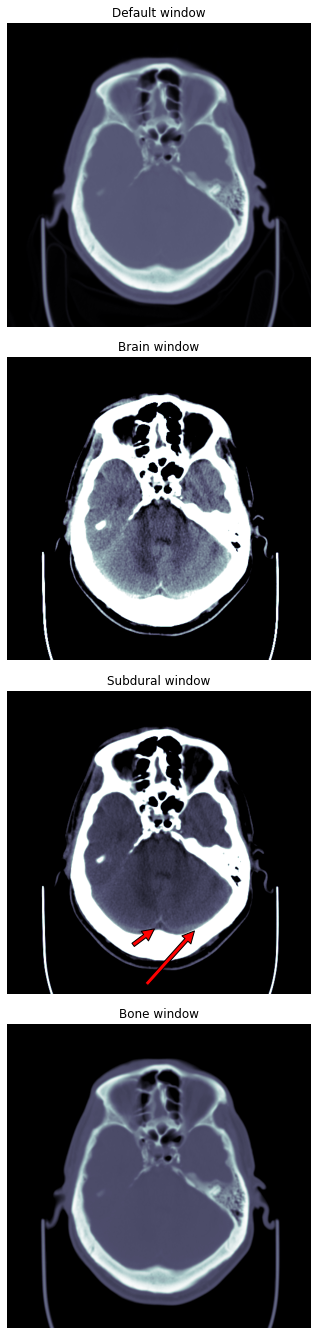

In [119]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex='col', figsize=(10,24), gridspec_kw={'hspace': 0.1, 'wspace': 0})

ax1.set_title('Default window')
im1 = ax1.imshow(pic.pixel_array,  cmap=plt.cm.bone)

ax2.set_title('Brain window')
#mg2 = window_image(img, 40, 80, intercept, slope)
im2 = ax2.imshow(pic2, cmap=plt.cm.bone)

ax3.set_title('Subdural window')
#img3 = window_image(img, 80, 200, intercept, slope)
im3 = ax3.imshow(pic3, cmap=plt.cm.bone)
ax3.annotate('', xy=(250, 400), xytext=(210, 430),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
ax3.annotate('', xy=(320, 400), xytext=(230, 500),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )

ax4.set_title('Bone window')
#img4 = window_image(img, 600, 2800, intercept, slope)
im4 = plt.imshow(pic4, cmap=plt.cm.bone)

for ax in fig.axes:
    ax.axis("off")
    
plt.show()


**Model DenseNet169**

In [25]:
if torch.cuda.is_available:
    device=torch.device('cuda')
else:
    device=torch.device('cpu')
densenet169=models.densenet169()
fc_in_features = densenet169.classifier.in_features

densenet169.classifier=torch.nn.Linear(fc_in_features,2)

dense=densenet169.to(device)

In [9]:
import time
from PIL import Image
device = torch.device('cuda')
train_df_path = '/scratch/hg1580/kaggle/stage1_train.csv'
val_df_path = '/scratch/hg1580/kaggle/stage1_valid.csv'
test_df_path='/scratch/hg1580/kaggle/stage1_test.csv'
transformed_dataset = {'train': BrainCTDataset_ResNet(train_df_path,transform=None,i=1), \
                       'validate':BrainCTDataset_ResNet(val_df_path,transform=None,i=1), \
                      'test': BrainCTDataset_ResNet(test_df_path,transform=None,i=1)}
bs = 5
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs, shuffle=False, num_workers=0) \
              for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}
optimizer = torch.optim.Adam(dense1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [6]:

def train_model(model, dataloader, optimizer, loss_fn, num_epochs = 10, verbose = False, scheduler=None):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
            print('Epoch: {}/{}'.format(i, num_epochs-1))
            print('-'*10)
        
            running_correct = 0
            running_loss = 0
            running_total = 0
                
            for data in dataloader['train']:
                model.train()
                optimizer.zero_grad()
                image = data['x'].to(device,dtype=torch.float)
                label = data['y'].to(device,dtype=torch.long)
                output = model(image)
                
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                
                loss.backward()
                optimizer.step()
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))
            
            acc_dict['train'].append(epoch_acc)
            loss_dict['train'].append(epoch_loss)
            
            
            with torch.no_grad():
                running_correct = 0
                running_loss = 0
                running_total = 0

                for data in dataloader['validate']:
                    model.eval()
                    optimizer.zero_grad()
                    image = data['x'].to(device,dtype=torch.float)
                    label = data['y'].to(device,dtype=torch.long)
                    output = model(image)
                    #print(image.shape)
                    loss = loss_fn(output, label)
                    _, preds = torch.max(output, dim = 1)
                    num_imgs = image.size()[0]
                    running_correct += torch.sum(preds ==label).item()
                    running_loss += loss.item()*num_imgs
                    running_total += num_imgs
                    
                epoch_acc = float(running_correct/running_total)
                epoch_loss = float(running_loss/running_total)
                if verbose or (i%10 == 0):
                    print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format('validate', epoch_loss, epoch_acc))

                acc_dict['validate'].append(epoch_acc)
                loss_dict['validate'].append(epoch_loss)

                
                
                
            
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model, acc_dict, loss_dict

In [8]:
model,acc_dict,loss_dict=train_model(dense,dataloader,optimizer,criterion,num_epochs=10,verbose=True)


Epoch: 0/9
----------
Phase:train, epoch loss: 0.5155 Acc: 0.7312
Phase:validate, epoch loss: 0.3383 Acc: 0.8903
Epoch: 1/9
----------
Phase:train, epoch loss: 0.3763 Acc: 0.8289
Phase:validate, epoch loss: 0.2711 Acc: 0.9121
Epoch: 2/9
----------
Phase:train, epoch loss: 0.3374 Acc: 0.8526
Phase:validate, epoch loss: 0.2829 Acc: 0.8978
Epoch: 3/9
----------
Phase:train, epoch loss: 0.3120 Acc: 0.8654
Phase:validate, epoch loss: 0.2469 Acc: 0.9120
Epoch: 4/9
----------
Phase:train, epoch loss: 0.2906 Acc: 0.8760
Phase:validate, epoch loss: 0.2477 Acc: 0.9132
Epoch: 5/9
----------
Phase:train, epoch loss: 0.2720 Acc: 0.8847
Phase:validate, epoch loss: 0.2235 Acc: 0.9220
Epoch: 6/9
----------
Phase:train, epoch loss: 0.2533 Acc: 0.8946
Phase:validate, epoch loss: 0.2263 Acc: 0.9192
Epoch: 7/9
----------
Phase:train, epoch loss: 0.2337 Acc: 0.9035
Phase:validate, epoch loss: 0.2178 Acc: 0.9215
Epoch: 8/9
----------
Phase:train, epoch loss: 0.2145 Acc: 0.9125
Phase:validate, epoch loss: 0.

In [9]:
torch.save(model.state_dict(),'/scratch/hg1580/kaggle/densenet_best_out2.pickle')

In [10]:
torch.save((acc_dict,loss_dict),'/scratch/hg1580/kaggle/densenet_acc_loss_out2.pickle')

Text(0.5, 1.0, 'train loss vs eopchs')

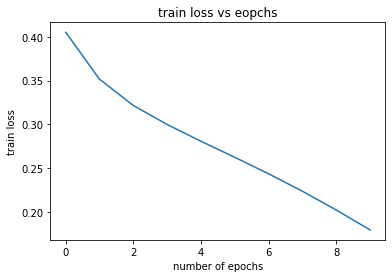

In [13]:
plt.plot(range(10),loss_dict['train'])
plt.xlabel('number of epochs')
plt.ylabel('train loss')
plt.title('train loss vs eopchs')



Text(0.5, 1.0, 'validation loss vs eopchs')

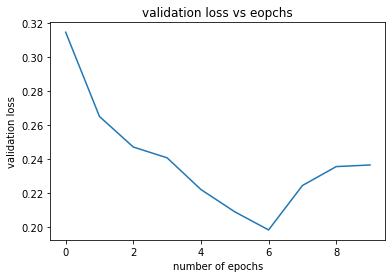

In [15]:
plt.plot(range(10),loss_dict['validate'])
plt.xlabel('number of epochs')
plt.ylabel('validation loss')
plt.title('validation loss vs eopchs')

Text(0.5, 1.0, 'train accuracy vs eopchs')

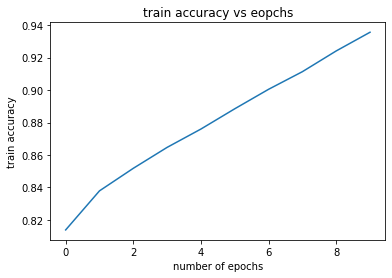

In [45]:
plt.plot(range(10),acc_dict['train'])
plt.xlabel('number of epochs')
plt.ylabel('train accuracy')
plt.title('train accuracy vs eopchs')

Text(0.5, 1.0, 'validation accuracy vs eopchs')

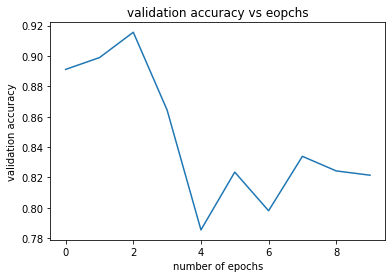

In [46]:
plt.plot(range(10),acc_dict['validate'])
plt.xlabel('number of epochs')
plt.ylabel('validation accuracy')
plt.title('validation accuracy vs eopchs')

In [27]:
import pickle
mo1 = models.densenet169()
fc_in_features = densenet169.classifier.in_features

mo1.classifier=torch.nn.Linear(fc_in_features,2)
mo1.load_state_dict(torch.load('/scratch/hg1580/kaggle/densenet_best_out2.pickle'))
mo2=mo1.to(device)

In [42]:
def evaluate_model(model, dataloader,loss_fn, phase = 'validate'):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    probs=[]
    truth=[]
    prediction=[]
    for data in dataloader[phase]:
        image = data['x'].to(device)
        label = data['y'].to(device)
        output = model(image)
        loss = loss_fn(output, label)
        prob=soft(output).T[1]
        probs+=prob.to('cpu').tolist()
        truth +=label.to('cpu').tolist()
        _, preds = torch.max(output,dim = 1)
        prediction+= preds.to('cpu').tolist()
        num_imgs = image.size()[0]
        running_correct += torch.sum(preds ==label).item()
        running_loss += loss.item()*num_imgs
        running_total += num_imgs
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)
    
    return accuracy, loss, probs, truth, prediction

In [43]:
acc_new, loss_new, probs, truth, prediction= evaluate_model(mo2, dataloader, criterion, phase='test')

In [46]:
acc_new

0.9369804618117229

In [33]:
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model 
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [34]:
def plotUnivariateROC(preds, truth, label_string):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    

    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)


    c = (np.random.rand(), np.random.rand(), np.random.rand())

    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

0.9330846286638877

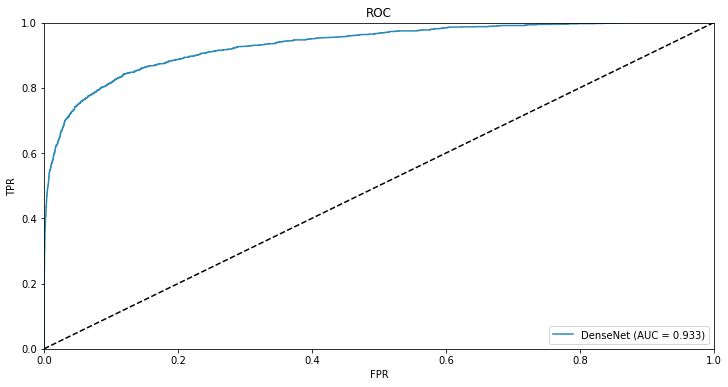

In [35]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plotUnivariateROC(np.array(probs), np.array(truth), 'DenseNet')


**Conparison between Resnet18 and Densenet169**

In [37]:
def plot_confusion_matrix(cm, title, classes):      
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)     
    plt.title(title)       
    plt.colorbar()     
    tick_marks = np.arange(len(classes))       
    plt.xticks(tick_marks, classes, rotation=45)       
    plt.yticks(tick_marks, classes)        

    thresh = cm.max() / 2.        
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):     
        plt.text(j, i, format(cm[i, j], 'd'),      
            horizontalalignment="center",     
            color="white" if cm[i, j] > thresh else "black")      

    plt.tight_layout()        
    plt.ylabel('True label')       
    plt.xlabel('Predicted label')

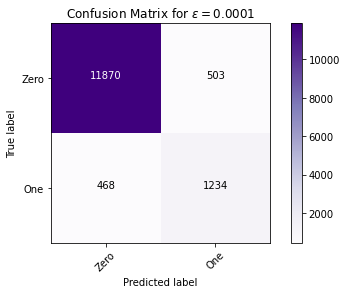

In [38]:
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(truth, prediction)
plt.figure()
plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(0.0001), classes=["Zero", "One"])


In [ ]:
import pickle
mo1 = models.resnet18()
fc_in_features = mo1.fc.in_features
mo1.fc = torch.nn.Linear(fc_in_features, 2)

mo1.load_state_dict(torch.load('/scratch/hg1580/kaggle/resnet_best_out2.pickle'))
mo2=mo1.to(device)

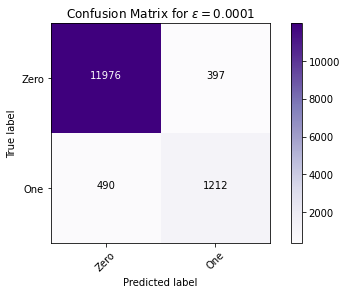

In [45]:
acc_new, loss_new, probs, truth, prediction= evaluate_model(mo2, dataloader, criterion, phase='test')
cnf_matrix = confusion_matrix(truth, prediction)
plt.figure()
plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(0.0001), classes=["Zero", "One"])


**Attemp for pretrained DenseNet169**

In [7]:
densenet169_pre=models.densenet169(pretrained=True)
fc_in_features = densenet169_pre.classifier.in_features

densenet169_pre.classifier=torch.nn.Linear(fc_in_features,2)

dense1=densenet169_pre.to(device)

In [39]:
model1,acc_dict1,loss_dict1=train_model(dense1,dataloader,optimizer,criterion,num_epochs=10,verbose=True)


Epoch: 0/9
----------
Phase:train, epoch loss: 0.4356 Acc: 0.7915
Phase:validate, epoch loss: 0.2340 Acc: 0.9179
Epoch: 1/9
----------
Phase:train, epoch loss: 0.3666 Acc: 0.8367
Phase:validate, epoch loss: 0.2204 Acc: 0.9248
Epoch: 2/9
----------
Phase:train, epoch loss: 0.3340 Acc: 0.8546
Phase:validate, epoch loss: 0.2282 Acc: 0.9225
Epoch: 3/9
----------
Phase:train, epoch loss: 0.3122 Acc: 0.8649
Phase:validate, epoch loss: 0.2203 Acc: 0.9238
Epoch: 4/9
----------
Phase:train, epoch loss: 0.2922 Acc: 0.8753
Phase:validate, epoch loss: 0.2223 Acc: 0.9183
Epoch: 5/9
----------
Phase:train, epoch loss: 0.2749 Acc: 0.8847
Phase:validate, epoch loss: 0.2086 Acc: 0.9256
Epoch: 6/9
----------
Phase:train, epoch loss: 0.2594 Acc: 0.8923
Phase:validate, epoch loss: 0.1933 Acc: 0.9315
Epoch: 7/9
----------
Phase:train, epoch loss: 0.2428 Acc: 0.8999
Phase:validate, epoch loss: 0.1991 Acc: 0.9286
Epoch: 8/9
----------
Phase:train, epoch loss: 0.2276 Acc: 0.9073
Phase:validate, epoch loss: 0.

In [40]:
torch.save(model1.state_dict(),'/scratch/hg1580/kaggle/densenet_best_out2_pre.pickle')

In [41]:
torch.save((acc_dict1,loss_dict1),'/scratch/hg1580/kaggle/densenet_acc_loss_out2_pre.pickle')